<a href="https://colab.research.google.com/github/ArsheenSingh/-Transfer-Learning-on-ResNet-50-Model-on-STL10-Dataset-using-PyTorch/blob/main/transfer_learning_ResNet_STL10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.manual_seed(42)

In [ ]:
import torch
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop (80-100% of original size)
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images with 50% probability
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For the test set, we do not apply augmentation (only resizing and normalization)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)


100%|██████████| 2.64G/2.64G [02:47<00:00, 15.8MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
# Iterate through a single batch to check
for images, labels in train_loader:
    print(f'Batch image tensor shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break

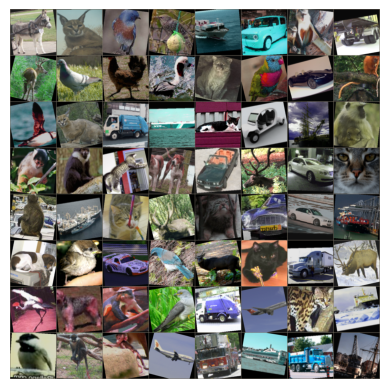

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
def imshow(img):

    # Denormalizing
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Denormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis("off")
    plt.show()

# Get a batch of training images for visualization
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Creating a grid of images
grid_img = vutils.make_grid(images, nrow=8)
imshow(grid_img)

In [7]:
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=test_transform)

Files already downloaded and verified


In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

In [9]:

import torchvision.models as models
from torchvision.models import ResNet50_Weights

ResNet_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [10]:
ResNet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in ResNet_model.parameters():
    param.requires_grad = False  # Freeze all
for param in ResNet_model.layer3.parameters():
    param.requires_grad = True  # Unfreeze layer3
for param in ResNet_model.layer4.parameters():
    param.requires_grad = True  # Unfreeze layer4

In [12]:
ResNet_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [13]:
ResNet_model=ResNet_model.to(device)

In [14]:
epochs = 20

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {'params': ResNet_model.layer3.parameters(), 'lr': 0.001},
    {'params': ResNet_model.layer4.parameters(), 'lr': 0.001},
    {'params': ResNet_model.fc.parameters(), 'lr': 0.01}
], momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [16]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = ResNet_model(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()



  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
torch.Size([

In [17]:
ResNet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = ResNet_model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.979125


In [19]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = ResNet_model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9968
